In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
from lib.Signature import Signature, Basepoint, sig_lreg, Cumsum2
from lib.Utilities import plot_nsde, plot_baseline
from lib.NSDE import SigNSDE
from lib.Baseline import ConditionalGenerator

In [3]:
data = torch.load('data/data.pt')

for dataset in data:
    data[dataset] = data[dataset].float()

In [4]:
sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data['X_train'].shape[2],
                  interval=[0, data['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['X_train'][:, :, 0].max()).to('cpu')

sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data['Y_train'].shape[2],
                  interval=[0, data['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['Y_train'][:, :, 0].max()).to('cpu')

In [5]:
signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data, 528, alpha=0.1, normalize_sig = True)

MSE train: 0.7678 MSE val: 1.1136 MSE test: 0.7100


In [6]:
sig_size = sig_X(torch.zeros_like(data['X_train'][:1])).shape[1]
data_size = 1
cvector_size = 32
initial_noise_size = 16
hidden_size = 48
architectures = {'initial': [32], 'drift': [84], 'diffusion': [84]}
t_norm=None
noise_size = 8
noise_type = 'diagonal'
final_tanh = True
proj = False
translation = False

In [7]:
G_NSDE = SigNSDE(sig_size, data_size, cvector_size, initial_noise_size, hidden_size, architectures, t_norm, 
            noise_size, noise_type, final_tanh, proj, translation).to(device)

load_model = True
if load_model:
    G_NSDE.load_state_dict(torch.load('nsde_sigwgan/G.pt'))

In [8]:
G_lstm_sig = ConditionalGenerator(1, 1, 32, 5, 5, True).to('cuda')
load_model = True
if load_model:
    G_lstm_sig.load_state_dict(torch.load('lstm_sigwgan/G.pt'))

In [9]:
G_lstm = ConditionalGenerator(1, 1, 32, 5, 5, True).float().to('cuda')
load_model = True
if load_model:
    G_lstm.load_state_dict(torch.load('lstm_wgan/G.pt'))

In [10]:
stats = torch.load('data/stats_data.pt')

In [11]:
torch.manual_seed(2)

In [12]:
X_data = data['X_test'].cpu()
Y_data = data['Y_test'].cpu()
sig_X = signatures_X['test']
nsamples_fs=5
device='cpu'

q = Y_data.shape[1]-1
nsamples=2
indexs = torch.randint(0, X_data.shape[0], (nsamples,)).to(device)
X, Y, sig_X = X_data[indexs].to(device), Y_data[indexs].to(device), sig_X[indexs].to(device)

## NSDE

In [15]:
G_NSDE = G_NSDE.to('cpu')
with torch.no_grad():
    X_mc, sig_X_mc = X.repeat(nsamples_fs, 1, 1).requires_grad_(), sig_X.repeat(nsamples_fs, 1).requires_grad_()
    pred_Y_NSDE = G_NSDE(sig_X_mc, X_mc[:, :, 1:], q).view(nsamples_fs, nsamples, q+1, 1)
    
pred_Y_NSDE = pred_Y_NSDE*stats['std']+stats['mean']

## LSTM SIGWGAN

In [16]:
G_lstm_sig = G_lstm_sig.to('cpu')
with torch.no_grad():
    X_mc, sig_X_mc = X.repeat(nsamples_fs, 1, 1).requires_grad_(), sig_X.repeat(nsamples_fs, 1).requires_grad_()
    pred_Y_lstmsig = G_lstm_sig(X_mc[:, :, 1:], q).view(nsamples_fs, nsamples, q+1, 1)
    
pred_Y_lstmsig = pred_Y_lstmsig*stats['std']+stats['mean']

## LSTM WGAN

In [17]:
G_lstm = G_lstm.to('cpu')
with torch.no_grad():
    X_mc, sig_X_mc = X.repeat(nsamples_fs, 1, 1).requires_grad_(), sig_X.repeat(nsamples_fs, 1).requires_grad_()
    pred_Y_lstm = G_lstm(X_mc[:, :, 1:], q).view(nsamples_fs, nsamples, q+1, 1)
    
pred_Y_lstm = pred_Y_lstm*stats['std']+stats['mean']

In [18]:
X[:, :, 1:] = X[:, :, 1:]*stats['std']+stats['mean']
Y[:, :, 1:] = Y[:, :, 1:]*stats['std']+stats['mean']

In [19]:
xticks = np.arange(0, 160, 30)
newxticks = np.array(['0min', '15min', '30min', '45min', '60min', '75min'])

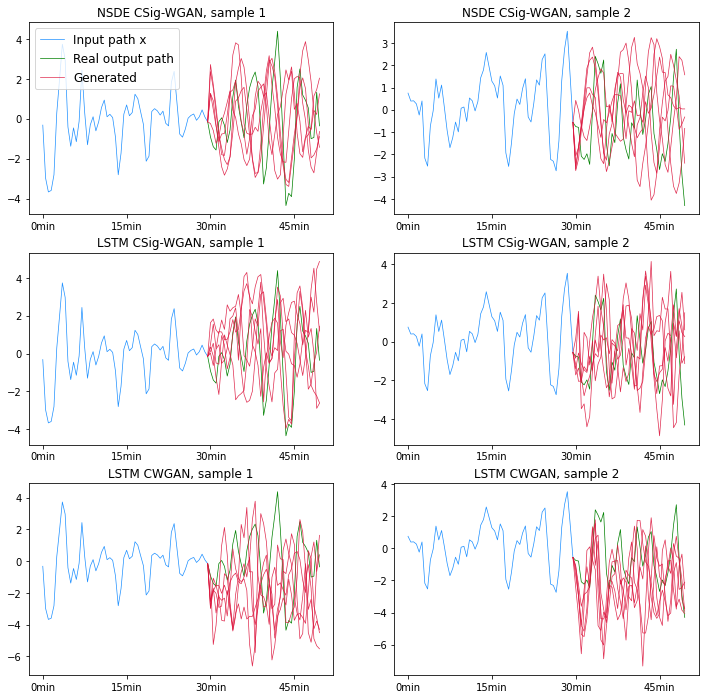

In [23]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, axs = plt.subplots(3,2)
pos = np.array([[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]])

for k in range(6): 
    
    i = k%2
    axs[pos[k, 0], pos[k, 1]].set_xticks(xticks, newxticks) 
    if k == 0:
        axs[pos[k, 0], pos[k, 1]].set_title('NSDE CSig-WGAN, sample 1')
    if k == 1:
        axs[pos[k, 0], pos[k, 1]].set_title('NSDE CSig-WGAN, sample 2')
    if k == 2:
        axs[pos[k, 0], pos[k, 1]].set_title('LSTM CSig-WGAN, sample 1')
    if k == 3:
        axs[pos[k, 0], pos[k, 1]].set_title('LSTM CSig-WGAN, sample 2')
    if k == 4:
        axs[pos[k, 0], pos[k, 1]].set_title('LSTM CWGAN, sample 1')
    if k == 5:
        axs[pos[k, 0], pos[k, 1]].set_title('LSTM CWGAN, sample 2')
        
    axs[pos[k, 0], pos[k, 1]].yaxis.set_major_formatter
    axs[pos[k, 0], pos[k, 1]].plot(X[i, :, 0], X[i, :, 1], color='dodgerblue', linewidth=0.7, alpha=1, label='Input path x')
    axs[pos[k, 0], pos[k, 1]].plot(Y[i, :, 0]+X[i, -1, 0], Y[i, :, 1], color='green', linewidth=0.7, alpha=1, 
                                   label='Real output path')
    for j in range(nsamples_fs):
        if k in [0,1]:
            pred_Y = pred_Y_NSDE
        elif k in [2,3]:
            pred_Y = pred_Y_lstm
        elif k in [4,5]:
            pred_Y = pred_Y_lstmsig
            
        if (i == 0) & (j==0):
            axs[pos[k, 0], pos[k, 1]].plot(Y[i, :, 0]+X[i, -1, 0], pred_Y[j, i, :, 0], color='crimson', linewidth=0.7, 
                                               alpha=0.9, label='Generated')  
        else:
            axs[pos[k, 0], pos[k, 1]].plot(Y[i, :, 0]+X[i, -1, 0], pred_Y[j, i, :, 0], color='crimson', linewidth=0.7, 
                                               alpha=0.9) 
    if i == 0:
        axs[0,0].legend(fontsize=12)
        
resolution_value = 600
plt.savefig("plots.png", format="png", dpi=resolution_value)
     
plt.show()
